In [2]:
# Imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, einsum
import torch.nn.functional as F
from scipy.stats import norm

In [3]:
# For reproducible results
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Task 1 - 1D diffusion process

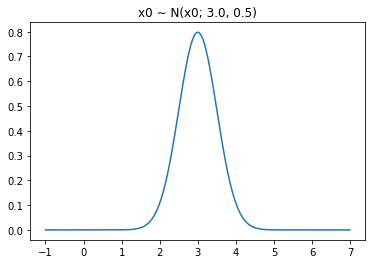

In [3]:
# x0 ∼ N(x0; m, p)
m = 3.0
p = 0.5

# Plot distribution of x0
x_axis = np.arange(-1, 7, 0.01)
plt.title(f"x0 ∼ N(x0; {m}, {p})")
plt.plot(x_axis, norm.pdf(x_axis, m, p))
plt.show()

In [4]:
# Iteratively runs forward diffusion on x0 for T timesteps
# returns: [x0, ... , xT]
def forward_diffuse(x0, T, Bt=0.25):
    xts = [x0]
    xt_prev = x0
    for i in range(T):
        ut = np.sqrt(1 - Bt) * xt_prev
        sigmat = np.sqrt(Bt)               # Bt*I = Bt*1 in the one dimensional case
        xt = np.random.normal(ut, sigmat)  # Using formula (1) from the project description; N.B. std instead of var since this is expected numpy arg
        xts.append(xt)
        xt_prev = xt
    return xts

In [5]:
# Uses closed formula to instantly compute xT from x0
# returns: xT
def forward_diffuse_closed(x0, T, Bt=0.25):
    at = 1 - Bt
    at_prod = np.power(at, T)
    uT = np.sqrt(at_prod) * x0
    sigmaT = np.sqrt(1 - at_prod)
    return np.random.normal(uT, sigmaT)

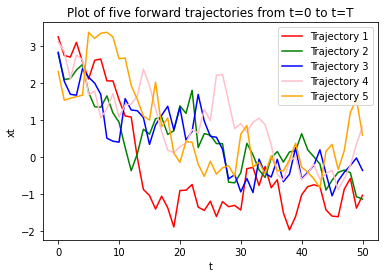

In [6]:
# Visualizing a few forward trajectories
T = 50
ts = range(0, T+1)
colors = ['red', 'green', 'blue', 'pink', 'orange']
for i in range(5):
    x0 = np.random.normal(m, p)
    xts = forward_diffuse(x0, T)
    plt.plot(ts, xts, color=colors[i], label=f"Trajectory {i+1}")
plt.legend()
plt.xlabel('t')
plt.ylabel('xt')
plt.title('Plot of five forward trajectories from t=0 to t=T')  
plt.show()

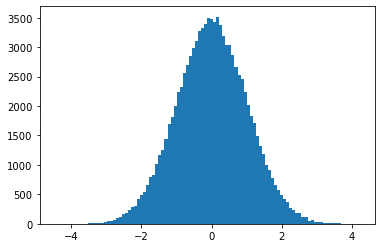

mean: 0.008170375464225088
std: 1.001863117753053


In [7]:
# Visualize the distrubution of xT, approximated from n trajectories
n = 100000    # more samples => better approximation => use closed formula for more efficient computation
xTs = []
for i in range(n):
    x0 = np.random.normal(m, p)
    xT = forward_diffuse_closed(x0, T)
    xTs.append(xT)

plt.hist(xTs, 100)
plt.show()

# Also compute mean and std of xT
print(f"mean: {np.mean(xTs)}\nstd: {np.std(xTs)}")

In [8]:
# Iteratively computes the reverse process, as a function of xt, x0, and t
# returns: [xt, ..., x0] where xi, i<t are the backward trajected values
def backward_diffuse(xt, t, x0, Bt=0.25):
    xts_reversed = [xt]
    at = 1 - Bt
    while(t > 0):
        at_prod = np.power(at, t)
        c1 = np.sqrt(at)*(1-at_prod/at) / (1-at_prod)
        c2 = np.sqrt(at_prod/at)*Bt / (1-at_prod)
        ut_tilde = c1*xt + c2*x0
        Bt_tilde = (1-at_prod/at) / (1-at_prod) * Bt
        xt_prev = np.random.normal(ut_tilde, np.sqrt(Bt_tilde))  # Compute q( x(t-1) | x(t), x(0) )
        xts_reversed.append(xt_prev)
        xt = xt_prev
        t = t-1
    return xts_reversed

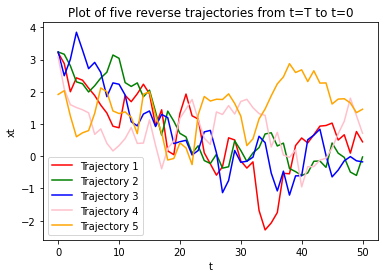

In [9]:
# Visualizing a few reverse trajectories
ts = range(0, T+1)
colors = ['red', 'green', 'blue', 'pink', 'orange']
for i in range(5):
    xT = np.random.normal(0, 1)
    x0 = np.random.normal(m, p)
    xts_reversed = backward_diffuse(xT, T, x0)
    xts = list(reversed(xts_reversed))    # just for plot, since ts is not reversed
    plt.plot(ts, xts, color=colors[i], label=f"Trajectory {i+1}")
plt.legend()
plt.xlabel('t')
plt.ylabel('xt')
plt.title('Plot of five reverse trajectories from t=T to t=0')  
plt.show()

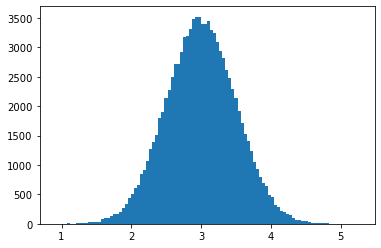

mean: 2.9981123694280862
std: 0.4987826034155103


In [10]:
# Visualize the distrubution of x0, approximated from n reverse trajectories
n = 100000    # more samples => better approximation => TODO: closed formula?
x0s = []
for i in range(n):
    xT = np.random.normal(0, 1)
    x0 = np.random.normal(m, p)
    x0_prim = backward_diffuse(xT, T, x0)[-1]   # should be equal to x0
    x0s.append(x0_prim)

plt.hist(x0s, 100)
plt.show()

# Also compute mean and std of x0
print(f"mean: {np.mean(x0s)}\nstd: {np.std(x0s)}")

## Task 2 - Learning a neural network to predict shapes from noise

In [4]:
# Returns the points in a txt file as a 2D ndarray
def read_points(file):
    with open(file, 'r') as f:
        lines = [line.rstrip('\n').split() for line in f]  # 2D array of shape [n, 2] with the point values as strings
        pts = np.zeros([len(lines), 2])
        for i, (x,y) in enumerate(lines):
            pts[i, 0] = float(x)
            pts[i, 1] = float(y)
        return pts

In [7]:
dinohead_pts.shape


(10240, 2)

<function matplotlib.pyplot.show(close=None, block=None)>

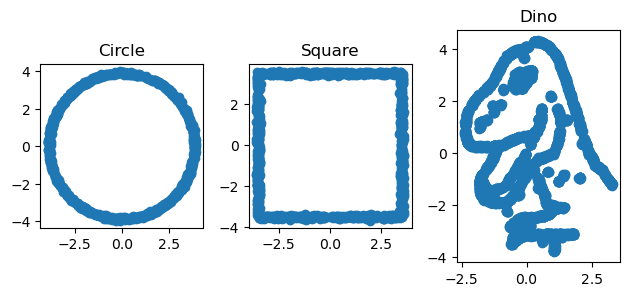

In [21]:
data_path = 'data'

circle_pts = read_points(os.path.join(data_path, 'circle_pts.txt'))
square_pts = read_points(os.path.join(data_path, 'square_pts.txt'))
dinohead_pts = read_points(os.path.join(data_path, 'dinohead_pts.txt'))

# Plot the original shapes
fig, axes = plt.subplots(1, 3)
axes[0].scatter(circle_pts[:, 0], circle_pts[:, 1])
axes[0].set_title('Circle')
axes[0].set_aspect('equal')
axes[1].scatter(square_pts[:, 0], square_pts[:, 1])
axes[1].set_title('Square')
axes[1].set_aspect('equal')
axes[2].scatter(dinohead_pts[:, 0], dinohead_pts[:, 1])
axes[2].set_title('Dino')
axes[2].set_aspect('equal')
plt.tight_layout()
plt.show

## Drafts (TODO: remove)

In [11]:
# Iteratively computes the reverse process, as a function of xt and t 
# (x0 is actually ignored since it can be represented as a function of xt, at_prod and et)*
# returns: [xt, ..., x0]
def backward_diffuse(xt, t, x0=None, Bt=0.25):
    xts_reversed = [xt]
    at = 1 - Bt
    while(t > 0):
        et = np.random.normal(0, 1)   # For representing x0 and simplifying formula for ut_tilde
        at_prod = np.power(at, t)
        ut_tilde = (1/at) * (xt - (1-at)/(np.sqrt(1-at_prod))*et)
        Bt_tilde = (1-at_prod/at) / (1-at_prod) * Bt
        xt_prev = np.random.normal(ut_tilde, np.sqrt(Bt_tilde))  # Compute q( x(t-1) | x(t), x(0) )
        xts_reversed.append(xt_prev)
        xt = xt_prev
        t = t-1
    return xts_reversed

# *TODO: reversed trajectored x0:s are huge! something not right in representation?